## 0. Introduction

In this notebook, we will look at three difference methods attempting to apply Topological data analysis (TDA) methods to financial data. 

Theorecitcal Background of persistence homology can be found in e.g. https://raphaeltinarrage.github.io/EMAp.html. 

For computation of persistence homology, we rely on GUDHI https://gudhi.inria.fr/.

## 1. Predicting financial bubbles

In https://arxiv.org/pdf/1703.04385, https://arxiv.org/pdf/1809.00695 and https://arxiv.org/pdf/2304.06877 the authors suggest that TDA methods, particularly norms of persistence landscapes can be used to detect financial bubbles. 

In this section, we will implement accroding to the papers, and applied to NVDA and HSI to investigate whether this makes sense or not.

### 1a. Background

In https://arxiv.org/pdf/1703.04385, this TDA method is applied to 4 major financial indices (S&P 500,
DJIA, NASDAQ, and Russel 2000) between December 23, 1987 and December 08, 2016 to investigate the trend before two major crashes: technology crash of 2000, and the financial crisis of 2007-2009.

In https://arxiv.org/pdf/1809.00695, a slightly different version is applied to 4 cryptocurrencies – Bitcoin, Ethereum, Litecoin, and Ripple from the beginning of 2016 to early 2018 to crashes during December 2017 – January
2018.

In https://arxiv.org/pdf/2304.06877, a comparison between this TDA method and the LPPLS model is made, and a heuristic argument is provided for the ability of detecting early warning signals of critical transitions. This method is applied again to the Bitcoin price between October 1st 2021 and July 1st 2022, and compared alongside with the LPPLS model.

### 1b. Implementation

Import packages

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 

import yfinance as yf
from math import log, sqrt
import pandas as pd
import numpy as np
import gudhi as gd
from datetime import date

Download/Load data to pandas dataframe

`log_return` computes the log return from adjusted close price.

In [2]:
def log_return(data):
    return ((data/data.shift())[1:]).apply(log)

`get_norms` perform the followings:

First, it uses time-delay embedding embed log return times series to `embedding_dim` dimension. 

After that, it uses sliding windows to form time varying point clouds. 

Finally, it uses `compute_norm` to compute the norm of landscapes as a pandas series. Note the index of series is taken as the latest date appeared in the window.

Here, `compute_norm` returns the norm of persistence landscape for data point cloud `Z` given.

In [3]:
embedding_dim = 4
time_delay = 5
window_length = 10

def compute_norm(Z):
    acZ = gd.RipsComplex(points=Z).create_simplex_tree(max_dimension = 2) #Create Rips complex as simplex tree
    dgmZ = acZ.persistence(homology_coeff_field = 2) #Compute persistence in Z/2Z coefficient.
    norm_1 = sum([((y-x)/2)**2 for x,y in acZ.persistence_intervals_in_dimension(1)]) #1-norm of landscape of 1-d persistent homology
    norm_2 = sqrt(sum([((y-x)**3)/12 for x,y in acZ.persistence_intervals_in_dimension(1)])) #2-norm
    norm_inf = max([((y-x)/2) for x,y in acZ.persistence_intervals_in_dimension(1)]) if len(acZ.persistence_intervals_in_dimension(1)) else 0 #inf-norm
    return {'1':norm_1, '2':norm_2, 'inf':norm_inf}

def get_norms(log_return,norm = '2',embedding_dim = embedding_dim,time_delay = time_delay, window_length = window_length):
    if norm not in ['1','2','inf']:
        raise ValueError(f"Norm must be '1','2', or 'inf'. Current norm: {norm}")
    series_len = len(log_return)
    time_delay_coord = [log_return[i:embedding_dim*time_delay+i:time_delay] for i in range(series_len-embedding_dim+1)] #time-delay embedding
    Z = pd.Series([time_delay_coord[t:t+window_length] for t in range(series_len-(embedding_dim-1)*time_delay - window_length + 1)]) #sliding windows
    return pd.Series([compute_norm(z)[norm] for z in Z], index = [max(time_delay_coord[t+window_length-1].index) for t in range(series_len-(embedding_dim-1)*time_delay - window_length + 1)])

### 1c. Applying to data

We will apply the above functions to the NVDA dataset, to get the norm of landscapes. 

And we will plot the norms against time as a graph.

In [4]:
'''start = '2024-01-01'
end = '2025-01-01'
name = asset+'-'+start+'-'+end+'.xlsx'
data = yf.download(asset, start=start, end=end)
data.to_excel(name)'''

'''asset = "NVDA"
period = "1y"
name = asset + '-' + period + str(date.today()) + '.xlsx'
data = yf.download(asset,period = period)
data.to_excel(name)'''

NVDA_data = pd.read_excel(r"C:\Users\Tom Li\NVDA-1y2025-02-12.xlsx",index_col = 0,header = [0,1])['Close'].iloc[:,0]

<Axes: title={'center': 'NVDA'}, ylabel='landscape norm'>

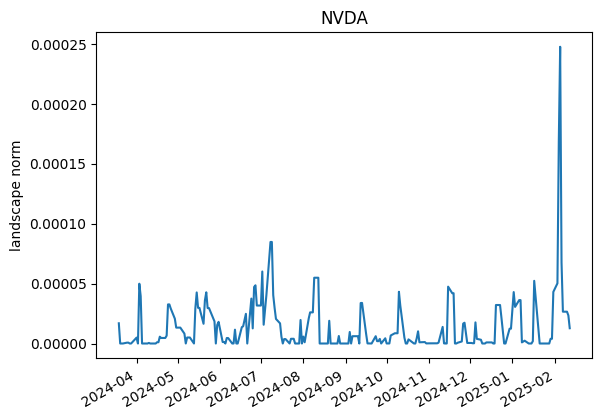

In [5]:
norm_time = get_norms(log_return(NVDA_data),norm = '1')
norm_time.plot(title = 'NVDA', ylabel = 'landscape norm')

### 1d. Interpreting the result

We see that there is an increasing trend of landscape norm in 2024-06 to 2024-07. Following https://arxiv.org/pdf/1703.04385 and https://arxiv.org/pdf/1809.00695, the rising trend might be a signal indicating later crash in asset price. Comparing with stock price, this might suggest the drop experience from \\$134.91 in 2024-07-10 to \\$98.91 in 2024-08-07. 

We also see a peak of landscape norm in 2025-02-05. According to https://arxiv.org/pdf/2304.06877, spike in the diagram might corresponds to either positive (increase followed by a crash) or negative (decay followed by a rebound) bubbles. This might suggest the bubble from the crest at \\$116.66 in 2025-02-03 to the peak at \\$140.11 in 2025-02-20 to the crest at \\$106.98 in 2025-03-10.

We perform one more example on Hong Kong's HSI.

<Axes: title={'center': 'HSI'}, ylabel='landscape norm'>

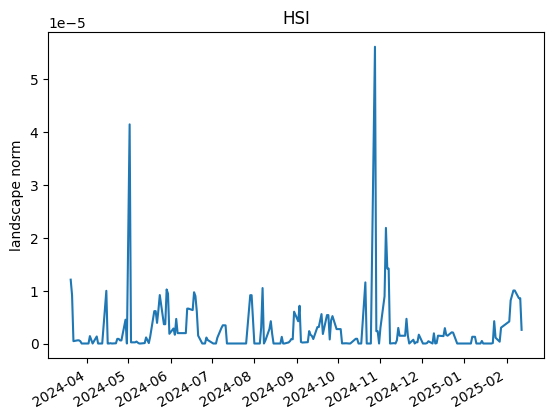

In [6]:
HSI_data = pd.read_excel(r"C:\Users\Tom Li\^HSI-1y2025-02-12.xlsx",index_col = 0,header = [0,1])['Close'].iloc[:,0]
norm_time = get_norms(log_return(HSI_data),norm = '1')
norm_time.plot(title = 'HSI' ,ylabel = 'landscape norm')

Compare with the index value, the spike near 2024-04-30 might suggest the bubble from 18507 at 2024-05-02, to the peak of 19636 at 2024-05-20, dropping back to 18079 at 2024-05-31 again. 

The spike at 2024-10-28 might indicate the drop from 21006 at 2024-11-05 to 19426 at 2024-11-14.

Unfortunately, the norm did not predict the rising trend of the bubble from 17108 at 2024-09-11 to 23099 at 2024-10-07, nor the crashing from 23099 at 2024-10-07 to 20079 at 2024-10-17.

## 2. Portfolio Allocation

In https://arxiv.org/pdf/2009.03362, inspired by the Recency Frequency Monetary framework (RFM), a TDA method for portfolio allocation is suggested. We will try to apply this method to a big-tech MANAMANA data set.

### 2a. Background

The idea is to perform time-delay embedding similar as above, and use the L2 norm of persistence landscape to compute a version of recency, frequency and monetary. These RFM values are then normalized to provide an allcation weighting.

We will apply this method to the big tech MANAMANA stocks, which includes: Microsoft, Apple, Netflix, Alphabet, Meta, Amazon, Nvidia, Adobe. This TDA-RFM allocation will give a weighting, so we can form a portfolio of these 8 stocks weighted with the corresponding weighting. We will compare its performance against a naive portfolio i.e. equally weighted.

For the training data set, we use 1 year (2022-2023) data; for the testing data set, we use 2023-2025 data to test.

###  2b. Parameters and data reading

First, we set the parameters and read the data. After that we perform the train-test splitting.

In [7]:
embedding_dim = 4
time_delay = 1
window_length = 10

MANAMANA = ['MSFT','AAPL','NFLX','GOOG','META','AMZN','NVDA','ADBE']

'''asset = "MANAMANA"
start = '2022-01-01'
end = '2025-01-01'
name = asset+'-'+start+'-'+end+'.xlsx'
data = yf.download(MANAMANA, start=start, end=end)
data.to_excel(name)'''

'''asset = "MANAMANA"
period = "1y"
name = asset + '-' + period + str(date.today()) + '.xlsx'
data = yf.download(MANAMANA,period = period)
data.to_excel(name)'''

MANAMANA_raw = pd.read_excel(r"C:\Users\Tom Li\MANAMANA-2022-01-01-2025-01-01.xlsx",
                              index_col = 0,header = [0,1])['Close']
MANAMANA_train = MANAMANA_raw[:'2023-01-01']
MANAMANA_test = MANAMANA_raw['2023-01-01':]

### 2c. Allocation computation

We compute the $L^2$ norm of persistence landscape. After that, we obtain the recency, frequency, and monetary values from the $L^2$ norms.

In [8]:
MANAMANA_L2 = pd.DataFrame({stock: get_norms(log_return(MANAMANA_train[stock]),norm = '2',
                                              embedding_dim = embedding_dim,
                                              time_delay = time_delay, 
                                              window_length = window_length)
                             for stock in  MANAMANA_train.columns})
MANAMANA_diff_L2 = (MANAMANA_L2-MANAMANA_L2.shift())[1:]

recency = {}
for stock in MANAMANA_diff_L2.columns:
    cnt = 0
    for num in MANAMANA_diff_L2[stock][::-1]:
        if num>0:
            cnt += 1
        else:
            break
    recency[stock] = cnt

frequency = {stock:sum(MANAMANA_diff_L2[stock]>0) for stock in MANAMANA_diff_L2.columns}
monetary = {stock:sum(MANAMANA_diff_L2[stock]) for stock in MANAMANA_diff_L2.columns}

Performing the normalization, we get the allocation weighting.

In [9]:
def normalize(dicts):
    return {stock:(v-min(dicts.values()))/(max(dicts.values())-min(dicts.values())) for stock,v in dicts.items()}
scores = {stock:normalize(recency)[stock]+normalize(frequency)[stock]+normalize(monetary)[stock] for stock in MANAMANA_diff_L2.columns}
allocations = {stock:score/sum(scores.values()) for stock,score in scores.items()}
allocations

{'AAPL': 0.16248039942382766,
 'ADBE': 0.10436842730052745,
 'AMZN': 0.19687628665141857,
 'GOOG': 0.09222479906678235,
 'META': 0.06968587541130737,
 'MSFT': 0.23786644199401755,
 'NFLX': 0.05861264576254696,
 'NVDA': 0.0778851243895722}

### 2d. Result comparison

Now we compare the increment of the TDA-RFM portfolio with the naive portfolio.

In [10]:
print(f'''TDA-RFM allocation: {sum(MANAMANA_test[stock].iloc[-1]/MANAMANA_test[stock]["2023-01-01":].iloc[0]*allocation 
    for stock,allocation in allocations.items())}''')
print(f'''Naive allocation: {sum(MANAMANA_test[stock].iloc[-1]/MANAMANA_test[stock]["2023-01-01":].iloc[0]*(1/len(allocations)) 
for stock in allocations)}''')

TDA-RFM allocation: 2.8282909111807566
Naive allocation: 3.367504719271582


Although in https://arxiv.org/pdf/2009.03362, the author obtain better result using TDA-RFM allocation, the TDA-RFM allocation is worse than the naive allocation in our MANAMANA data set. This might due to 2 reasons: 

1. Our MANAMANA set is simply too small. Due to limitation of resources, we cannot apply to such a huge dataset, unlike the authors having a server with 256GB RAM, 40 CPUs.
2. Our implementation is different from the authors. There are a few spots in the paper reflecting mathematical errors which might affect our understanding of the algorithm.

One error is the definition of monetary value. The monetary value is defined as the sum of the difference in $L^2$ norms. It is nearly impossible for it to be valued in $\mathbb{N}$, contradicting claims elsewhere in the paper that all RFM are $\mathbb{N}$ valued. Also due to telescoping, the monetary value is simply just the last value minus the first value, there are no room for deep relation embedding inside.

Other error includes the definition of $C$. It is very absurd in set theorectical sense.

Also, some pararmeters are simply not provided in the paper. This includes for example the embedding dimension $d$. 

## 3. Portfolio Selection

In https://arxiv.org/pdf/2308.07944, the authors suggested a TDA method for portfolio selections, we will apply this method once again to the MANAMANA dataset to test the performance. 

### 3a. Pipeline

Using the best performing model presetning in the paper, the pipeline goes as follows:

First, consider a large collection of stocks. For each stock in the collection, use the stock price to compute the persistence image as an embedding to a fixed high dimensional space, i.e. each stock is represented as a point in a fixed high dimensional space.

Next, apply $k$-mean clustering to classify the collection of stocks to clusters.

For each cluster, we choose a small fixed amount of best performing stocks according to Sharpe ratio.

The resulting small amount of stocks in each cluster will be the selected portfolio.

### 3b. Persistent Image computation

First we will compute the persistence diagram of the stock prices.

In [11]:
def get_pt_cloud(log_return):
    series_len = len(log_return)
    return [log_return[i:embedding_dim*time_delay+i:time_delay].values for i in range(series_len-embedding_dim+1)]

def compute_dgm(Z,dim = 1,coeff = 2):
    acZ = gd.RipsComplex(points=Z).create_simplex_tree(max_dimension = dim+1) #Create Rips complex as simplex tree
    acZ.persistence(homology_coeff_field = coeff)
    return acZ.persistence_intervals_in_dimension(dim)

MANAMANA_PD = {stock:compute_dgm(get_pt_cloud(log_return(MANAMANA_train[stock])))
                            for stock in MANAMANA_train.columns}

We compute the persistence image from the persistence diagram. The persistence image allows us to view the stocks as points in a high dimensional space.

In [12]:
from gudhi.representations import PersistenceImage
PI_dict = {stock:PersistenceImage().fit_transform(X = [MANAMANA_PD[stock]]) for stock in MANAMANA_PD}
PI_item = list(PI_dict.items())

### 3c. Clustering and stock selection

Next, we perform $k$-mean clustering, we can see the labels assigned to each stock.

In [13]:
from sklearn.cluster import KMeans
X = np.array([PI_item[i][1][0] for i in range(len(PI_item))])
n_clusters = 3
kmeans = KMeans(n_init = 'auto',n_clusters = n_clusters,random_state = 114514).fit(X)
print([(x[0],kmeans.labels_[i]) for i,x in enumerate(PI_item)])

[('AAPL', 2), ('ADBE', 2), ('AMZN', 1), ('GOOG', 1), ('META', 2), ('MSFT', 0), ('NFLX', 1), ('NVDA', 1)]


Choose the best performing stocks in terms of sharpe ratios to get the selected stocks.

In [14]:
selected_stocks = {max((PI_item[j][0] for j,label in enumerate(kmeans.labels_) if label == i), 
                       key = lambda x:(MANAMANA_train[x].iloc[-1]/MANAMANA_train[x].iloc[0])/MANAMANA_train[x].std()) 
                   for i in range(n_clusters)}
selected_stocks

{'AAPL', 'MSFT', 'NVDA'}

### 3d. Result Comparison

Now we compare the increment of the PI-selected portfolio with the naive portfolio.

In [15]:
print(f'''PI selected portfolio: {sum(MANAMANA_test[stock].iloc[-1]/MANAMANA_test[stock]["2023-01-01":].iloc[0]*(1/len(selected_stocks)) 
    for stock in selected_stocks)}''')
print(f'''naive portfolio: {sum(MANAMANA_test[stock].iloc[-1]/MANAMANA_test[stock]["2023-01-01":].iloc[0]*(1/len(MANAMANA_PD)) 
    for stock in MANAMANA_PD)}''')

PI selected portfolio: 4.399795910155403
naive portfolio: 3.367504719271582


We see that the selected portfolio performs much better than the naive portfolio. Furthermore, the very well performing NVDA is selected by this algorithm, which is remarkable.